In [244]:
import pandas as pd
import numpy as np
from collections import defaultdict
import glob
import pickle

# Initialize alpha-beta distributions
alpha = defaultdict(lambda: 1)
beta = defaultdict(lambda: 1)

global_alpha = [1] * len(price_bins)
global_beta = [1] * len(price_bins)

agg_alpha_by_pickup = defaultdict(lambda: [1]*len(price_bins))
agg_beta_by_pickup = defaultdict(lambda: [1]*len(price_bins))

agg_alpha_by_dropoff = defaultdict(lambda: [1]*len(price_bins))
agg_beta_by_dropoff = defaultdict(lambda: [1]*len(price_bins))

# Define price bins clearly
price_bins = [(0.48,0.54),(0.54,0.6),(0.6,0.65),(0.65,0.7),(0.7,0.75),(0.75,0.8)]

def assign_arm(price):
    for idx, (low, high) in enumerate(price_bins):
        if low <= price < high:
            return idx
    return len(price_bins)-1

def discretize_state_size(size):
    return '0' if size==0 else '1-4' if size<=4 else '5-10' if size<=10 else '11+'

def discretize_avg_wait(wait):
    return '0-30' if wait<=30 else '31-100' if wait<=100 else '100+'

In [245]:
# Load weekly files separately
weeks_converted = sorted(glob.glob('week_*_converted_with_state.csv'))
weeks_non_converted = sorted(glob.glob('week_*_convert_0.csv'))

# iterate week by week explicitly
for week_idx, (conv_file, nonconv_file) in enumerate(zip(weeks_converted, weeks_non_converted), start=1):

    df_converted = pd.read_csv(conv_file)
    df_non_converted = pd.read_csv(nonconv_file)

    df_converted['convert_or_not'] = 1
    df_non_converted['convert_or_not'] = 0

    # Concatenate and sort this week's data explicitly
    df_week = pd.concat([df_converted, df_non_converted], ignore_index=True)
    df_week = df_week.sort_values(by='arrival_time').reset_index(drop=True)

    # Step 3: Explicitly RESET STATE EACH WEEK
    state = {}  # reset here explicitly (important)

    # Iterate clearly through riders of current week
    for idx, row in df_week.iterrows():
        t_now = row['arrival_time']  # continuous time is fine
        
        # Remove riders whose patience expired explicitly
        state = {rid: (arr, pat) for rid, (arr, pat) in state.items() if (t_now - arr) < pat}

        # Define context explicitly (with reset weekly state)
        context = (
            row['pickup_area'],
            row['dropoff_area'],
            discretize_state_size(len(state)),
            discretize_avg_wait(np.mean([t_now - arr for arr, _ in state.values()]) if state else 0)
        )

        # Update alpha-beta based on observed conversions clearly
        arm = assign_arm(row['quoted_price'])
        converted = row['convert_or_not']
        
        if converted:
            alpha[(context, arm)] += 1
            global_alpha[arm] += 1
            agg_alpha_by_pickup[row['pickup_area']][arm] +=1
            agg_alpha_by_dropoff[row['dropoff_area']][arm] +=1
            if row['waiting_time'] > 0:
                state[row['rider_id']] = (t_now, row['waiting_time'])
        else:
            beta[(context, arm)] += 1
            global_beta[arm] += 1
            agg_beta_by_pickup[row['pickup_area']][arm] +=1
            agg_beta_by_dropoff[row['dropoff_area']][arm] += 1

In [246]:
def pricing_policy(current_state, pickup_area, dropoff_area, t_now):
    context = (
        pickup_area,
        dropoff_area,
        discretize_state_size(len(current_state)),
        discretize_avg_wait(np.mean([t_now - arr for arr, _ in current_state.values()]) if current_state else 0)
    )

    best_arm, best_sample = None, -1
    for arm_idx in range(len(price_bins)):
        a, b = alpha[(context, arm_idx)], beta[(context, arm_idx)]
        sample = np.random.beta(a, b)
        if sample > best_sample:
            best_sample = sample
            best_arm = arm_idx

    # Use midpoint of bin explicitly
    chosen_price = np.mean(price_bins[best_arm])
    return chosen_price

In [247]:
def pricing_policy_generalized(current_state, pickup_area, dropoff_area, t_now):
    state_size = discretize_state_size(len(current_state))
    avg_wait = discretize_avg_wait(
        np.mean([t_now - arr for arr, _ in current_state.values()]) if current_state else 0
    )

    exact_context = (pickup_area, dropoff_area, state_size, avg_wait)

    # If exact context seen before, use it explicitly
    context_seen = any((exact_context, arm) in alpha for arm in range(len(price_bins)))
    if context_seen:
        context_to_use = exact_context
    else:
        if pickup_area in agg_alpha_by_pickup:
            a_pick = agg_alpha_by_pickup[pickup_area]
            b_pick = agg_beta_by_pickup[pickup_area]
        else:
            a_pick = [1] * len(price_bins)
            b_pick = [1] * len(price_bins)

        if dropoff_area in agg_alpha_by_dropoff:
            a_drop = agg_alpha_by_dropoff[dropoff_area]
            b_drop = agg_beta_by_dropoff[dropoff_area]
        else:
            a_drop = [1] * len(price_bins)
            b_drop = [1] * len(price_bins)
        
        a_combined = [(a1 + a2)/2 for a1, a2 in zip(a_pick, a_drop)]
        b_combined = [(b1 + b2)/2 for b1, b2 in zip(b_pick, b_drop)]

        # Thompson Sampling
        samples = [np.random.beta(a, b) for a, b in zip(a_combined, b_combined)]
        best_arm = np.argmax(samples)
        return np.mean(price_bins[best_arm])
#         samples = [np.random.beta(a, b) for a, b in zip(global_alpha, global_beta)]
#         best_arm = np.argmax(samples)
#         return np.mean(price_bins[best_arm])
#         # Explicit fallback: aggregate similar contexts
#         matching_contexts = [
#             ctx for ctx in alpha if ctx[0] == pickup_area or ctx[1] == dropoff_area
#         ]
        
#         if matching_contexts:
#             # Average alpha-beta from similar contexts clearly
#             aggregated_alpha_beta = [
#                 (np.mean([alpha[(ctx, arm)] for ctx in matching_contexts]),
#                  np.mean([beta[(ctx, arm)] for ctx in matching_contexts]))
#                 for arm in range(len(price_bins))
#             ]
#             best_arm = np.argmax([np.random.beta(a,b) for a,b in aggregated_alpha_beta])
#             return np.mean(price_bins[best_arm])
#         else:
#             # Final fallback explicitly if completely unseen: quote high price initially
#             return 0.65

    # Normal case: seen context explicitly
#     best_arm, best_sample = None, -1
#     for arm_idx in range(len(price_bins)):
#         a, b = alpha[(context_to_use, arm_idx)], beta[(context_to_use, arm_idx)]
#         sample = np.random.beta(a, b)
#         if sample > best_sample:
#             best_sample = sample
#             best_arm = arm_idx

#     return np.mean(price_bins[best_arm])
    samples = [
        (np.random.beta(alpha[(context_to_use, arm)], beta[(context_to_use, arm)]), arm)
        for arm in range(len(price_bins))
    ]
    
    # Sort samples descending by value
    top_k = sorted(samples, reverse=True)[:2]
    
    # Take the average of the prices of top-k arms
    top_prices = [np.mean(price_bins[arm]) for _, arm in top_k]
    
    return np.mean(top_prices)

In [248]:
class StudentPricingPolicy:
    # DO NOT MODIFY
    def __init__(self, c = 0.70):
        self.c = c

    # DO NOT MODIFY
    @staticmethod
    def get_name():
        return TEAM_NAME

    def pricing_function(self, state, rider):
        """
        Returns the price of the given rider in the given state

        Parameters
        ----------
        state: list
            list of rider(s) (object) waiting in the state
        rider: object
            An incoming rider

        Returns
        -------
        float
            The price of the rider: must be in [0, 1]
        """
        pickup_area = rider.pickup_area
        dropoff_area = rider.dropoff_area
        state_len = discretize_state_size(len(state))
        avg_waiting = np.mean([getattr(r, 'waiting_time', 0) or 0 for r in state]) if pool_size > 0 else 0
        
        exact_context = (pickup_area, dropoff_area, state_size, avg_wait)
        context_seen = any((exact_context, arm) in alpha for arm in range(len(price_bins)))
        
        # If exact context seen before, use it explicitly
        if context_seen:
            context_to_use = exact_context
            samples = [
                (np.random.beta(alpha[(context_to_use, arm)], beta[(context_to_use, arm)]), arm)
                for arm in range(len(price_bins))
            ]

            # Sort samples descending by value
            top_k = sorted(samples, reverse=True)[:2]

            # Take the average of the prices of top-k arms
            top_prices = [np.mean(price_bins[arm]) for _, arm in top_k]

            return np.mean(top_prices)

        else:
            if pickup_area in agg_alpha_by_pickup:
                a_pick = agg_alpha_by_pickup[pickup_area]
                b_pick = agg_beta_by_pickup[pickup_area]
            else:
                a_pick = [1] * len(price_bins)
                b_pick = [1] * len(price_bins)

            if dropoff_area in agg_alpha_by_dropoff:
                a_drop = agg_alpha_by_dropoff[dropoff_area]
                b_drop = agg_beta_by_dropoff[dropoff_area]
            else:
                a_drop = [1] * len(price_bins)
                b_drop = [1] * len(price_bins)

            a_combined = [(a1 + a2)/2 for a1, a2 in zip(a_pick, a_drop)]
            b_combined = [(b1 + b2)/2 for b1, b2 in zip(b_pick, b_drop)]

            # Thompson Sampling
            samples = [np.random.beta(a, b) for a, b in zip(a_combined, b_combined)]
            best_arm = np.argmax(samples)
            return np.mean(price_bins[best_arm])

## Test

Original Mean Price (rejected): 0.5996
New Policy Mean Suggested Price: 0.6487
Our policy suggested lower prices 339/922 (36.77%) times.


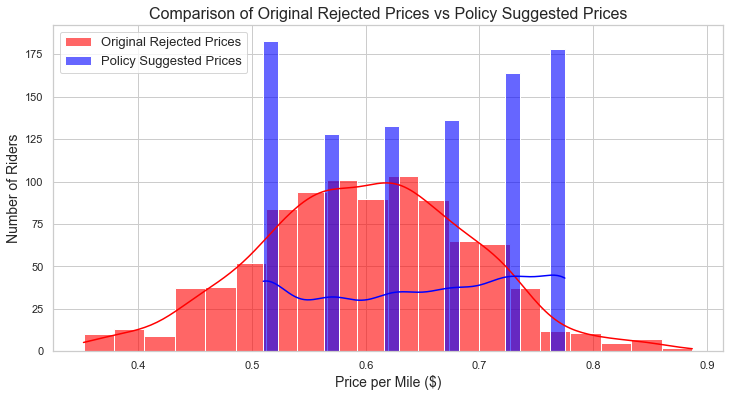

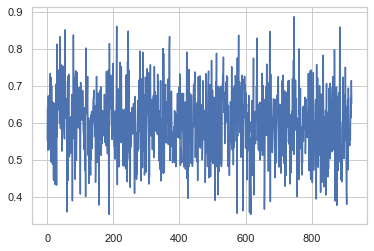

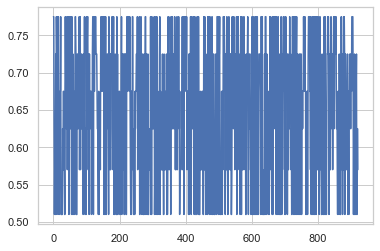

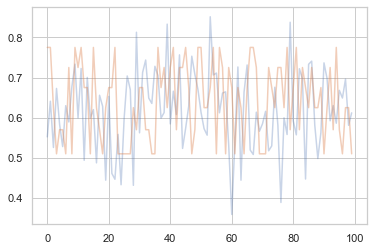

In [249]:
import time
# Week 1 example (use same for other weeks as needed)
df_conv = pd.read_csv('week_1_converted_with_state.csv')
df_nonconv = pd.read_csv('week_1_convert_0.csv')

df_conv['convert_or_not'] = 1
df_nonconv['convert_or_not'] = 0

# Explicitly mark rows to test (originally convert=0 riders)
df_nonconv['is_test_rider'] = True
df_conv['is_test_rider'] = False

# Merge clearly and sort
df_week = pd.concat([df_conv, df_nonconv], ignore_index=True)
df_week = df_week.sort_values(by='arrival_time').reset_index(drop=True)

# Prepare to record test results
df_week['new_policy_price'] = np.nan

state = {}  # explicitly initialize state
for idx, row in df_week.iterrows():
    t_now = row['arrival_time']

    # Remove expired riders explicitly
    state = {rid: (arr, pat) for rid, (arr, pat) in state.items() if (t_now - arr) < pat}

    # For riders marked as test riders (convert=0 originally)
    if row['is_test_rider']:
        suggested_price = pricing_policy(state, row['pickup_area'], row['dropoff_area'], t_now)
        df_week.at[idx, 'new_policy_price'] = suggested_price

    # Add riders who converted and have waiting time to state explicitly
    if row['convert_or_not'] == 1 and row['waiting_time'] > 0:
        state[row['rider_id']] = (t_now, row['waiting_time'])
        
# Explicitly filter test riders
df_test_results = df_week[df_week['is_test_rider']].copy()

# Explicit comparison
original_mean = df_test_results['quoted_price'].mean()
policy_mean = df_test_results['new_policy_price'].mean()

print(f"Original Mean Price (rejected): {original_mean:.4f}")
print(f"New Policy Mean Suggested Price: {policy_mean:.4f}")

# Explicitly check lower-price instances
lower_prices = (df_test_results['new_policy_price'] < df_test_results['quoted_price']).sum()
total = len(df_test_results)
print(f"Our policy suggested lower prices {lower_prices}/{total} ({lower_prices/total:.2%}) times.")

import matplotlib.pyplot as plt
import seaborn as sns

# Set up style explicitly
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(12, 6))

# Original prices (rejected by customers)
sns.histplot(df_test_results['quoted_price'], 
             bins=20, color='red', label='Original Rejected Prices', kde=True, alpha=0.6)

# New policy suggested prices
sns.histplot(df_test_results['new_policy_price'], 
             bins=20, color='blue', label='Policy Suggested Prices', kde=True, alpha=0.6)

# Clear annotations
plt.title('Comparison of Original Rejected Prices vs Policy Suggested Prices', fontsize=16)
plt.xlabel('Price per Mile ($)', fontsize=14)
plt.ylabel('Number of Riders', fontsize=14)
plt.legend(fontsize=13)

plt.show()

import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(len(df_test_results)), df_test_results['quoted_price'])
plt.show()
plt.plot(np.arange(len(df_test_results)), df_test_results['new_policy_price'])
plt.show()

plt.figure()
plt.plot(np.arange(100), df_test_results['quoted_price'][:100],alpha=0.3)
plt.plot(np.arange(100), df_test_results['new_policy_price'][:100],alpha=0.4)
plt.show()

In [250]:
# Week 1 example (use same for other weeks as needed)
df_conv = pd.read_csv('week_3_converted_with_state.csv')
df_nonconv = pd.read_csv('week_3_convert_0.csv')

df_conv['convert_or_not'] = 1
df_nonconv['convert_or_not'] = 0

# Explicitly mark rows to test (originally convert=0 riders)
df_nonconv['is_test_rider'] = False
df_conv['is_test_rider'] = True

# Merge clearly and sort
df_week = pd.concat([df_conv, df_nonconv], ignore_index=True)
df_week = df_week.sort_values(by='arrival_time').reset_index(drop=True)

# Prepare to record test results
df_week['new_policy_price'] = np.nan

Original Mean Price (rejected): 0.5323
New Policy Mean Suggested Price: 0.6527
Our policy suggested lower prices 185/1203 (15.38%) times.


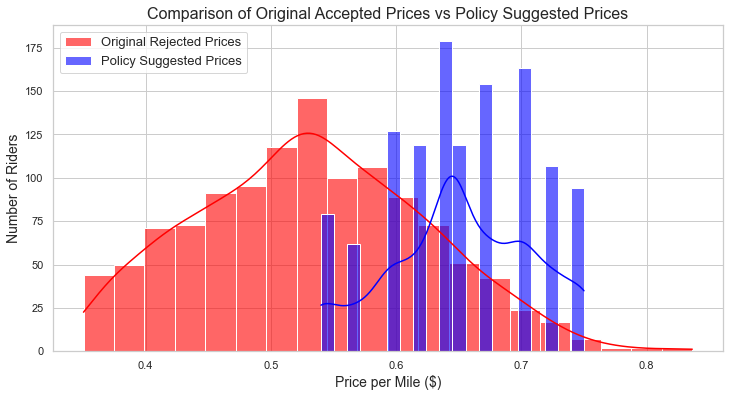

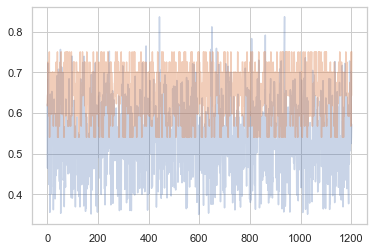

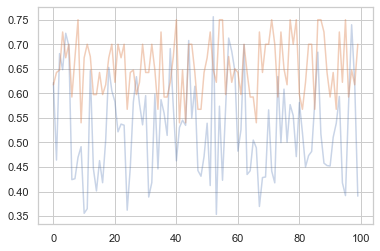

In [251]:
state = {}  # explicitly initialize state
for idx, row in df_week.iterrows():
    t_now = row['arrival_time']

    # Remove expired riders explicitly
    state = {rid: (arr, pat) for rid, (arr, pat) in state.items() if (t_now - arr) < pat}

    # For riders marked as test riders (convert=0 originally)
    if row['is_test_rider']:
        suggested_price = pricing_policy_generalized(state, row['pickup_area'], row['dropoff_area'], t_now)
        df_week.at[idx, 'new_policy_price'] = suggested_price

    # Add riders who converted and have waiting time to state explicitly
    if row['convert_or_not'] == 1 and row['waiting_time'] > 0:
        state[row['rider_id']] = (t_now, row['waiting_time'])
        
# Explicitly filter test riders
df_test_results = df_week[df_week['is_test_rider']].copy()

# Explicit comparison
original_mean = df_test_results['quoted_price'].mean()
policy_mean = df_test_results['new_policy_price'].mean()

print(f"Original Mean Price (rejected): {original_mean:.4f}")
print(f"New Policy Mean Suggested Price: {policy_mean:.4f}")

# Explicitly check lower-price instances
lower_prices = (df_test_results['new_policy_price'] < df_test_results['quoted_price']).sum()
total = len(df_test_results)
print(f"Our policy suggested lower prices {lower_prices}/{total} ({lower_prices/total:.2%}) times.")

import matplotlib.pyplot as plt
import seaborn as sns

# Set up style explicitly
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(12, 6))

# Original prices (rejected by customers)
sns.histplot(df_test_results['quoted_price'], 
             bins=20, color='red', label='Original Rejected Prices', kde=True, alpha=0.6)

# New policy suggested prices
sns.histplot(df_test_results['new_policy_price'], 
             bins=20, color='blue', label='Policy Suggested Prices', kde=True, alpha=0.6)

# Clear annotations
plt.title('Comparison of Original Accepted Prices vs Policy Suggested Prices', fontsize=16)
plt.xlabel('Price per Mile ($)', fontsize=14)
plt.ylabel('Number of Riders', fontsize=14)
plt.legend(fontsize=13)

plt.show()

import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(len(df_test_results)), df_test_results['quoted_price'],alpha=0.3)
plt.plot(np.arange(len(df_test_results)), df_test_results['new_policy_price'],alpha=0.4)
plt.show()

plt.figure()
plt.plot(np.arange(100), df_test_results['quoted_price'][:100],alpha=0.3)
plt.plot(np.arange(100), df_test_results['new_policy_price'][:100],alpha=0.4)
plt.show()

In [252]:
# Week 2 example (use same for other weeks as needed)
df_conv = pd.read_csv('week_2_converted_with_state.csv')
df_nonconv = pd.read_csv('week_2_convert_0.csv')

df_conv['convert_or_not'] = 1
df_nonconv['convert_or_not'] = 0

# Explicitly mark rows to test (originally convert=0 riders)
df_nonconv['is_test_rider'] = True
df_conv['is_test_rider'] = False

# Merge clearly and sort
df_week = pd.concat([df_conv, df_nonconv], ignore_index=True)
df_week = df_week.sort_values(by='arrival_time').reset_index(drop=True)

# Prepare to record test results
df_week['new_policy_price'] = np.nan

In [253]:
state = {}  # explicitly initialize state
for idx, row in df_week.iterrows():
    t_now = row['arrival_time']

    # Remove expired riders explicitly
    state = {rid: (arr, pat) for rid, (arr, pat) in state.items() if (t_now - arr) < pat}

    # For riders marked as test riders (convert=0 originally)
    if row['is_test_rider']:
        suggested_price = pricing_policy_generalized(state, row['pickup_area'], row['dropoff_area'], t_now)
        df_week.at[idx, 'new_policy_price'] = suggested_price

    # Add riders who converted and have waiting time to state explicitly
    if row['convert_or_not'] == 1 and row['waiting_time'] > 0:
        state[row['rider_id']] = (t_now, row['waiting_time'])

Original Mean Price (rejected): 0.6014
New Policy Mean Suggested Price: 0.6470
Our policy suggested lower prices 338/919 (36.78%) times.


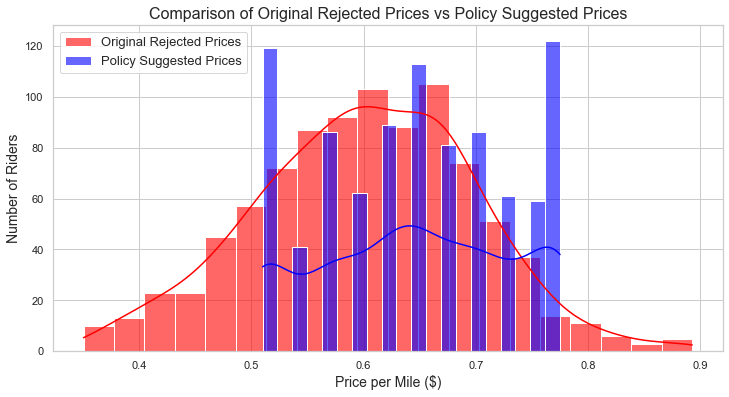

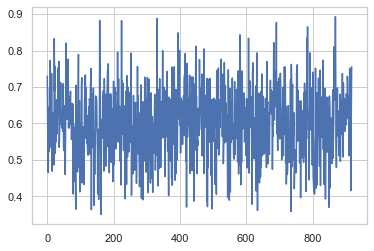

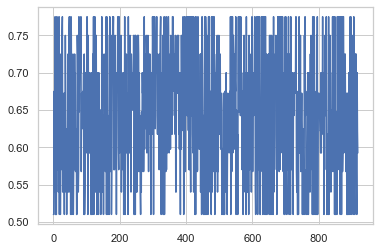

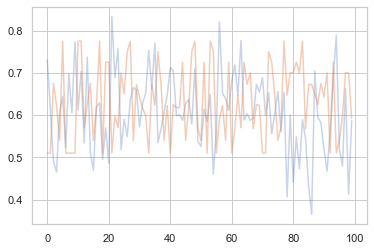

In [254]:
# Explicitly filter test riders
df_test_results = df_week[df_week['is_test_rider']].copy()

# Explicit comparison
original_mean = df_test_results['quoted_price'].mean()
policy_mean = df_test_results['new_policy_price'].mean()

print(f"Original Mean Price (rejected): {original_mean:.4f}")
print(f"New Policy Mean Suggested Price: {policy_mean:.4f}")

# Explicitly check lower-price instances
lower_prices = (df_test_results['new_policy_price'] < df_test_results['quoted_price']).sum()
total = len(df_test_results)
print(f"Our policy suggested lower prices {lower_prices}/{total} ({lower_prices/total:.2%}) times.")

import matplotlib.pyplot as plt
import seaborn as sns

# Set up style explicitly
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(12, 6))

# Original prices (rejected by customers)
sns.histplot(df_test_results['quoted_price'], 
             bins=20, color='red', label='Original Rejected Prices', kde=True, alpha=0.6)

# New policy suggested prices
sns.histplot(df_test_results['new_policy_price'], 
             bins=20, color='blue', label='Policy Suggested Prices', kde=True, alpha=0.6)

# Clear annotations
plt.title('Comparison of Original Rejected Prices vs Policy Suggested Prices', fontsize=16)
plt.xlabel('Price per Mile ($)', fontsize=14)
plt.ylabel('Number of Riders', fontsize=14)
plt.legend(fontsize=13)

plt.show()

import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(len(df_test_results)), df_test_results['quoted_price'])
plt.show()
plt.plot(np.arange(len(df_test_results)), df_test_results['new_policy_price'])
plt.show()

plt.figure()
plt.plot(np.arange(100), df_test_results['quoted_price'][:100],alpha=0.3)
plt.plot(np.arange(100), df_test_results['new_policy_price'][:100],alpha=0.4)
plt.show()

In [255]:
df_week = pd.read_csv('validation_riders_results_poop.csv')
# Prepare to record test results
df_week['new_policy_price'] = np.nan
state = {}  # explicitly initialize state
week = 1
for idx, row in df_week.iterrows():
    if row['arrival_week'] != week:
        week += 1
        state = {}
    t_now = row['arrival_time']

    # Remove expired riders explicitly
    state = {rid: (arr, pat) for rid, (arr, pat) in state.items() if (t_now - arr) < pat}

    # For riders marked as test riders (convert=0 originally)
    suggested_price = pricing_policy_generalized(state, row['pickup_area'], row['dropoff_area'], t_now)
    df_week.at[idx, 'new_policy_price'] = suggested_price

    # Add riders who converted and have waiting time to state explicitly
    if row['convert_or_not'] == 1 and row['waiting_time'] > 0:
        state[row['rider_id']] = (t_now, row['waiting_time'])

Original Mean Price (rejected): 0.8000
New Policy Mean Suggested Price: 0.6588
Our policy suggested lower prices 5138/5138 (100.00%) times.


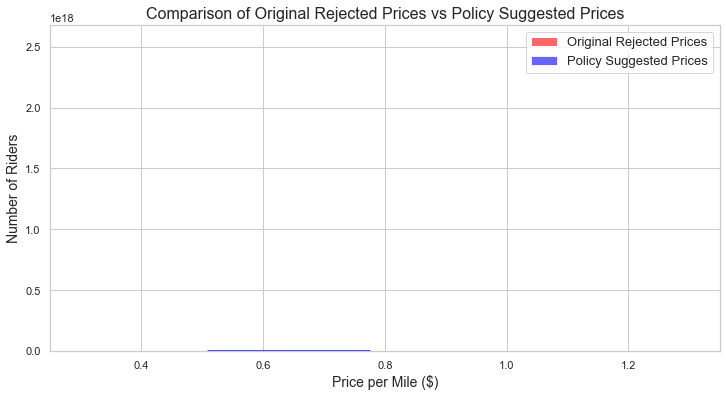

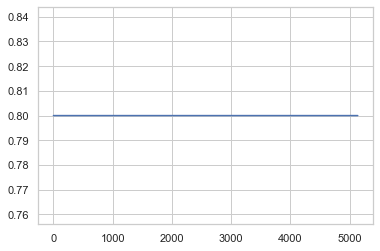

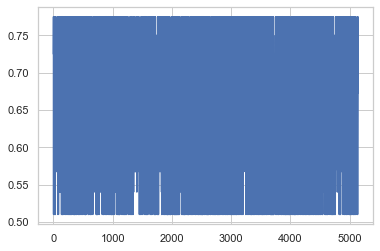

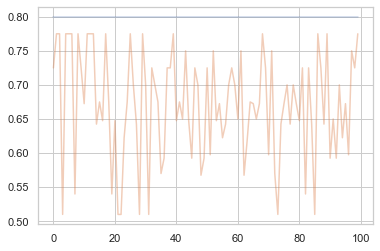

In [256]:
# Explicitly filter test riders
df_test_results = df_week.copy()

# Explicit comparison
original_mean = df_test_results['quoted_price'].mean()
policy_mean = df_test_results['new_policy_price'].mean()

print(f"Original Mean Price (rejected): {original_mean:.4f}")
print(f"New Policy Mean Suggested Price: {policy_mean:.4f}")

# Explicitly check lower-price instances
lower_prices = (df_test_results['new_policy_price'] < df_test_results['quoted_price']).sum()
total = len(df_test_results)
print(f"Our policy suggested lower prices {lower_prices}/{total} ({lower_prices/total:.2%}) times.")

import matplotlib.pyplot as plt
import seaborn as sns

# Set up style explicitly
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(12, 6))

# Original prices (rejected by customers)
sns.histplot(df_test_results['quoted_price'], 
             bins=20, color='red', label='Original Rejected Prices', kde=True, alpha=0.6)

# New policy suggested prices
sns.histplot(df_test_results['new_policy_price'], 
             bins=20, color='blue', label='Policy Suggested Prices', kde=True, alpha=0.6)

# Clear annotations
plt.title('Comparison of Original Rejected Prices vs Policy Suggested Prices', fontsize=16)
plt.xlabel('Price per Mile ($)', fontsize=14)
plt.ylabel('Number of Riders', fontsize=14)
plt.legend(fontsize=13)

plt.show()

import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(len(df_test_results)), df_test_results['quoted_price'])
plt.show()
plt.plot(np.arange(len(df_test_results)), df_test_results['new_policy_price'])
plt.show()

plt.figure()
plt.plot(np.arange(100), df_test_results['quoted_price'][:100],alpha=0.3)
plt.plot(np.arange(100), df_test_results['new_policy_price'][:100],alpha=0.4)
plt.show()
